# 1 Import Packages

In [1]:
import xarray as xr
import numpy as np
import os
import datetime
import src.config as config
import src.utils as utils

import sklearn.linear_model
from tqdm import tqdm
import cartopy.crs as ccrs
import joblib

import matplotlib.pyplot as plt

# 2 Metadata

In [2]:
lev_index = 0
kfold_index = 0
exp_name = "cv"
datetime_string = datetime.datetime.now().strftime("%d_%m_%Y_%H_%M_%S")


In [3]:
# Parameters
lev_index = "0"
kfold_index = "6"
datetime_string = "20_02_2023_17_03_08"


In [4]:
ml_transform_path = os.path.join(config.data_pro_path,"ml_transform", exp_name)

In [5]:
train_x_filename = "train_data_stack_lonlatstandardized_lev_{}_{}.nc".format(lev_index, kfold_index)
valid_x_filename = "valid_data_stack_lonlatstandardized_lev_{}_{}.nc".format(lev_index, kfold_index)

train_y_filename = "train_data_amoc_depth_1020_lat_26_samplestandardized_{}_{}.nc".format(lev_index, kfold_index)
valid_y_filename = "valid_data_amoc_depth_1020_lat_26_samplestandardized_{}_{}.nc".format(lev_index, kfold_index)

In [6]:
model_name = "linear_level_{}_kfold_{}".format(lev_index, kfold_index)
model_path = os.path.join(config.model_path,exp_name, datetime_string,model_name)

model_plot_path = os.path.join(model_path, "plots")
os.makedirs(model_plot_path, exist_ok=True)

# 3 Load Data

In [7]:
train_x_xr = xr.open_dataset(os.path.join(ml_transform_path, train_x_filename))
valid_x_xr = xr.open_dataset(os.path.join(ml_transform_path, valid_x_filename))

In [8]:
train_y_xr = xr.open_dataset(os.path.join(ml_transform_path, train_y_filename))
valid_y_xr = xr.open_dataset(os.path.join(ml_transform_path, valid_y_filename))

In [9]:
train_data_amoc_depth_1020_lat_26_samplestd  = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplestd.nc" ))
train_data_amoc_depth_1020_lat_26_samplemean = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplemean,nc"))

# 4 Processing

In [10]:
train_x_xr_stack = train_x_xr.stack(sample=("realization","time")).stack(feature=("lon","lat"))
valid_x_xr_stack = valid_x_xr.stack(sample=("realization","time")).stack(feature=("lon","lat"))

feature_coords = train_x_xr_stack.feature
sample_coords = train_x_xr_stack.sample

train_x_xr_stack_dropna = train_x_xr_stack.dropna(dim="feature")
valid_x_xr_stack_dropna = valid_x_xr_stack.dropna(dim="feature")

feature_dropna_coords = train_x_xr_stack_dropna.feature

In [11]:
train_y_xr_stack = train_y_xr.stack(sample=("realization","time"))
valid_y_xr_stack = valid_y_xr.stack(sample=("realization","time"))


# 5 Model

In [12]:
valid_sample_coords = valid_y_xr_stack.sample
train_sample_coords = train_y_xr_stack.sample

feature_drop_coords = train_x_xr_stack_dropna.feature
feature_full_coords = train_x_xr_stack.feature 

train_x_ml_xr = train_x_xr_stack_dropna["rho"]
valid_x_ml_xr = valid_x_xr_stack_dropna["rho"]

train_y_ml_xr = train_y_xr_stack["atlantic_moc"]
valid_y_ml_xr = valid_y_xr_stack["atlantic_moc"]

train_y_true_ml_xr = train_y_xr_stack["atlantic_moc"]
valid_y_true_ml_xr = valid_y_xr_stack["atlantic_moc"]


In [13]:
def mse_xr(pred, true, sample_dim = "sample"):
    return np.square(pred - true).mean(dim=sample_dim)

## 5.1 Train

In [14]:
alpha_list = np.logspace(-2,4, 100)

In [15]:
train_mse_list = []
valid_mse_list = []


for i,alpha in tqdm(enumerate(alpha_list)): 
    
    model = sklearn.linear_model.Ridge(alpha = alpha)
    
    model.fit(train_x_ml_xr, train_y_ml_xr)
    
    model_coef_ml_xr = xr.DataArray(model.coef_, dims = ["feature"], coords ={"feature":feature_drop_coords} )
    model_coef_tmp,_ = xr.align(model_coef_ml_xr, feature_coords, join="outer")

    train_y_pred_ml_np = model.predict(train_x_ml_xr)
    valid_y_pred_ml_np = model.predict(valid_x_ml_xr)

    train_y_pred_ml_xr = xr.DataArray(train_y_pred_ml_np, dims= ["sample"], coords = {"sample": train_sample_coords, "alpha":alpha})
    valid_y_pred_ml_xr = xr.DataArray(valid_y_pred_ml_np, dims= ["sample"], coords = {"sample": valid_sample_coords, "alpha":alpha})


    train_mse_tmp = mse_xr(train_y_pred_ml_xr, train_y_true_ml_xr)
    valid_mse_tmp = mse_xr(valid_y_pred_ml_xr, valid_y_true_ml_xr)
    
    model_name = "model_{}.sav".format(i)
    model_file = os.path.join(model_path, model_name)
    joblib.dump(model, model_file)
    

    if i == 0: 
        model_coef = model_coef_tmp.assign_coords({"alpha": alpha})
        train_mse = train_mse_tmp.assign_coords({"alpha":alpha})
        valid_mse = valid_mse_tmp.assign_coords({"alpha":alpha})
        train_pred = train_y_pred_ml_xr.assign_coords({"alpha":alpha})
        valid_pred = valid_y_pred_ml_xr.assign_coords({"alpha":alpha})

    else:
        model_coef = xr.concat([model_coef, model_coef_tmp.assign_coords({"alpha":alpha})], dim="alpha")
        train_mse = xr.concat([train_mse, train_mse_tmp.assign_coords({"alpha":alpha})], dim="alpha")
        valid_mse = xr.concat([valid_mse, valid_mse_tmp.assign_coords({"alpha":alpha})], dim="alpha")
        train_pred = xr.concat([train_pred, train_y_pred_ml_xr.assign_coords({"alpha":alpha})], dim="alpha")
        valid_pred = xr.concat([valid_pred, valid_y_pred_ml_xr.assign_coords({"alpha":alpha})], dim="alpha")
        

    data = xr.merge([
        model_coef.rename("coefficients"),
        train_mse.rename("train_mse"), 
        valid_mse.rename("valid_mse"),
        valid_pred.rename("valid_pred"),
        train_pred.rename("train_pred"),
        ])


0it [00:00, ?it/s]

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.19642e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


1it [00:02,  2.80s/it]

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.47968e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


2it [00:06,  3.25s/it]

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.80092e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


3it [00:09,  3.36s/it]

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.48199e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


4it [00:13,  3.57s/it]

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.91469e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


5it [00:17,  3.49s/it]

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.54037e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


6it [00:20,  3.57s/it]

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.28055e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


7it [00:24,  3.49s/it]

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.14818e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


8it [00:27,  3.47s/it]

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.05889e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


9it [00:30,  3.38s/it]

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.75083e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


10it [00:34,  3.40s/it]

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.44036e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


11it [00:37,  3.41s/it]

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.68327e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


12it [00:40,  3.27s/it]

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.05398e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


13it [00:43,  3.24s/it]

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.20794e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


14it [00:47,  3.28s/it]

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.38808e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


15it [00:50,  3.32s/it]

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.59755e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


16it [00:53,  3.28s/it]

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.84251e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


17it [00:56,  3.17s/it]

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.12636e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


18it [00:59,  3.12s/it]

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.74209e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


19it [01:02,  3.11s/it]

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.01901e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


20it [01:06,  3.17s/it]

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.28022e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


21it [01:09,  3.19s/it]

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.06855e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


22it [01:12,  3.17s/it]

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.8991e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


23it [01:15,  3.10s/it]

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.66961e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


24it [01:19,  3.30s/it]

25it [01:22,  3.40s/it]

26it [01:26,  3.50s/it]

27it [01:30,  3.53s/it]

28it [01:33,  3.48s/it]

29it [01:37,  3.52s/it]

30it [01:40,  3.47s/it]

31it [01:43,  3.47s/it]

32it [01:47,  3.40s/it]

33it [01:50,  3.32s/it]

34it [01:53,  3.32s/it]

35it [01:57,  3.40s/it]

36it [02:00,  3.40s/it]

37it [02:03,  3.31s/it]

38it [02:06,  3.31s/it]

39it [02:10,  3.43s/it]

40it [02:14,  3.55s/it]

41it [02:17,  3.47s/it]

42it [02:21,  3.58s/it]

43it [02:25,  3.56s/it]

44it [02:29,  3.69s/it]

45it [02:32,  3.72s/it]

46it [02:36,  3.55s/it]

47it [02:39,  3.53s/it]

48it [02:42,  3.44s/it]

49it [02:45,  3.35s/it]

50it [02:49,  3.41s/it]

51it [02:52,  3.36s/it]

52it [02:56,  3.38s/it]

53it [02:59,  3.22s/it]

54it [03:01,  3.15s/it]

55it [03:04,  3.09s/it]

56it [03:08,  3.08s/it]

57it [03:10,  3.03s/it]

58it [03:14,  3.06s/it]

59it [03:17,  3.03s/it]

60it [03:20,  3.18s/it]

61it [03:23,  3.24s/it]

62it [03:27,  3.29s/it]

63it [03:30,  3.33s/it]

64it [03:34,  3.36s/it]

65it [03:37,  3.38s/it]

66it [03:40,  3.34s/it]

67it [03:44,  3.39s/it]

68it [03:48,  3.50s/it]

69it [03:51,  3.50s/it]

70it [03:55,  3.55s/it]

71it [03:59,  3.60s/it]

72it [04:02,  3.56s/it]

73it [04:05,  3.50s/it]

74it [04:09,  3.46s/it]

75it [04:12,  3.55s/it]

76it [04:16,  3.65s/it]

77it [04:19,  3.48s/it]

78it [04:23,  3.50s/it]

79it [04:27,  3.59s/it]

80it [04:31,  3.71s/it]

81it [04:35,  3.83s/it]

82it [04:39,  3.90s/it]

83it [04:43,  4.02s/it]

84it [04:47,  4.02s/it]

85it [04:51,  3.94s/it]

86it [04:55,  3.95s/it]

87it [04:59,  3.97s/it]

88it [05:03,  3.97s/it]

89it [05:07,  4.09s/it]

90it [05:11,  4.07s/it]

91it [05:15,  3.96s/it]

92it [05:19,  3.98s/it]

93it [05:23,  4.03s/it]

94it [05:26,  3.70s/it]

95it [05:30,  3.81s/it]

96it [05:34,  3.81s/it]

97it [05:38,  3.91s/it]

98it [05:43,  4.04s/it]

99it [05:47,  4.10s/it]

100it [05:50,  3.95s/it]

100it [05:50,  3.51s/it]

## 5.2  Evaluation

In [16]:
train_corr = xr.corr(train_y_true_ml_xr, data["train_pred"], dim="sample").rename("train_corr")
valid_corr = xr.corr(valid_y_true_ml_xr, data["valid_pred"], dim="sample").rename("valid_corr")


In [17]:
diff = (data["train_mse"] - data["valid_mse"]).rename("diff_mse")

In [18]:
data = xr.merge([data, diff, train_corr, valid_corr])

In [19]:
data.unstack().assign_coords({"kfold_index": kfold_index}).to_netcdf(os.path.join(model_path, "data.nc"))

In [20]:
alpha_min_diff = data.alpha.isel(alpha = (np.abs(diff).argmin()))
alpha_min_val  = data.alpha.isel(alpha = data["valid_mse"].argmin())
alpha_min = data.alpha.min()
alpha_max = data.alpha.max()


Text(100.97222222222221, 0.5, 'Error')

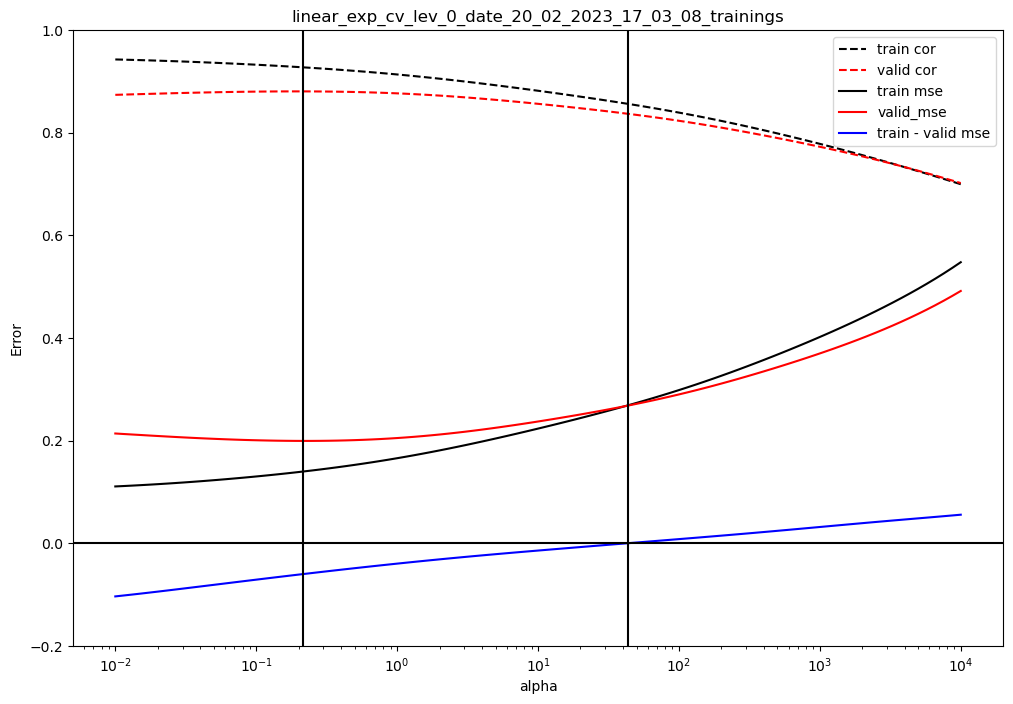

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(data.alpha, train_corr, color="black", linestyle="dashed", label="train cor")
plt.plot(data.alpha, valid_corr, color="red", linestyle="dashed", label="valid cor")
plt.plot(data.alpha, data["train_mse"], color="black", label="train mse")
plt.plot(data.alpha, data["valid_mse"], color="red",   label="valid_mse")
plt.plot(data.alpha, diff, color="blue", label="train - valid mse")
plt.xscale("log")

plt.axhline(0, color="black")
plt.axvline(alpha_min_diff.values.item(), color="black")
plt.axvline(alpha_min_val.values.item(), color="black")


plt.legend()

plt.ylim(-0.2,1)

name = "linear_exp_{}_lev_{}_date_{}_trainings".format(exp_name, lev_index, datetime_string )
plt.title(name)
plt.savefig(os.path.join(model_plot_path, name))
plt.xlabel("alpha")
plt.ylabel("Error")



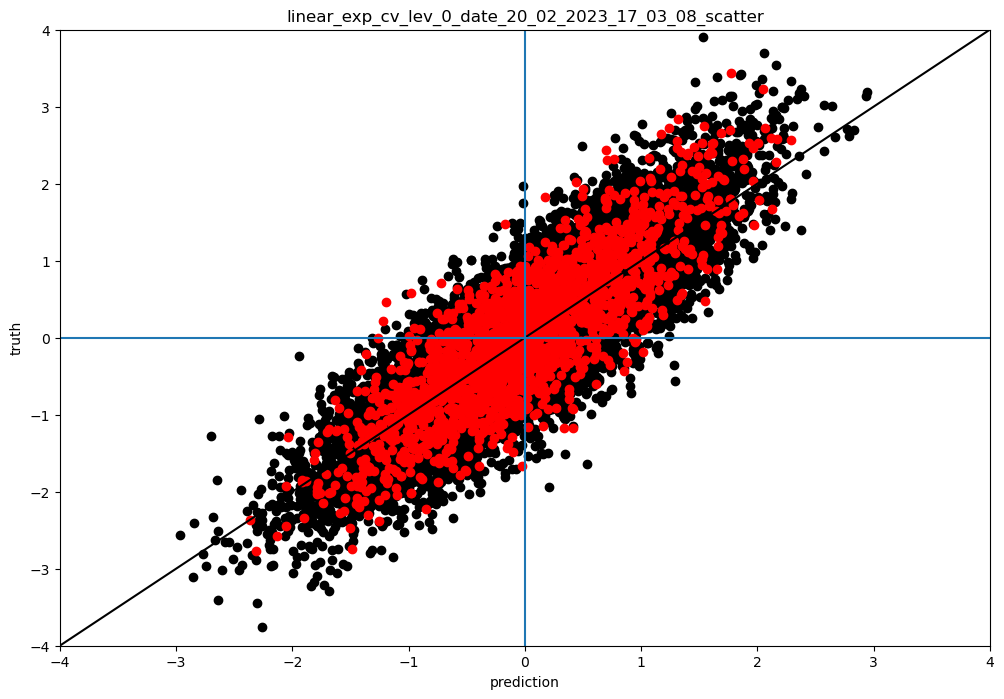

In [22]:

fig, ax = plt.subplots(figsize=(12,8))

plt.xlim(-4,4)
plt.ylim(-4,4)

plt.scatter(data["train_pred"].sel(alpha=alpha_min_diff).dropna(dim="sample", how="all"), train_y_true_ml_xr, color="black")
plt.scatter(data["valid_pred"].sel(alpha=alpha_min_diff).dropna(dim="sample", how="all"), valid_y_true_ml_xr, color="red")

x = np.arange(-4,5)


plt.plot(x,x, color="black")
plt.axhline(0)
plt.axvline(0)

plt.xlabel("prediction")
plt.ylabel("truth")


name = "linear_exp_{}_lev_{}_date_{}_scatter".format(exp_name, lev_index, datetime_string )
plt.title(name)
plt.savefig(os.path.join(model_plot_path, name))



In [23]:
coefficients = data["coefficients"].unstack()

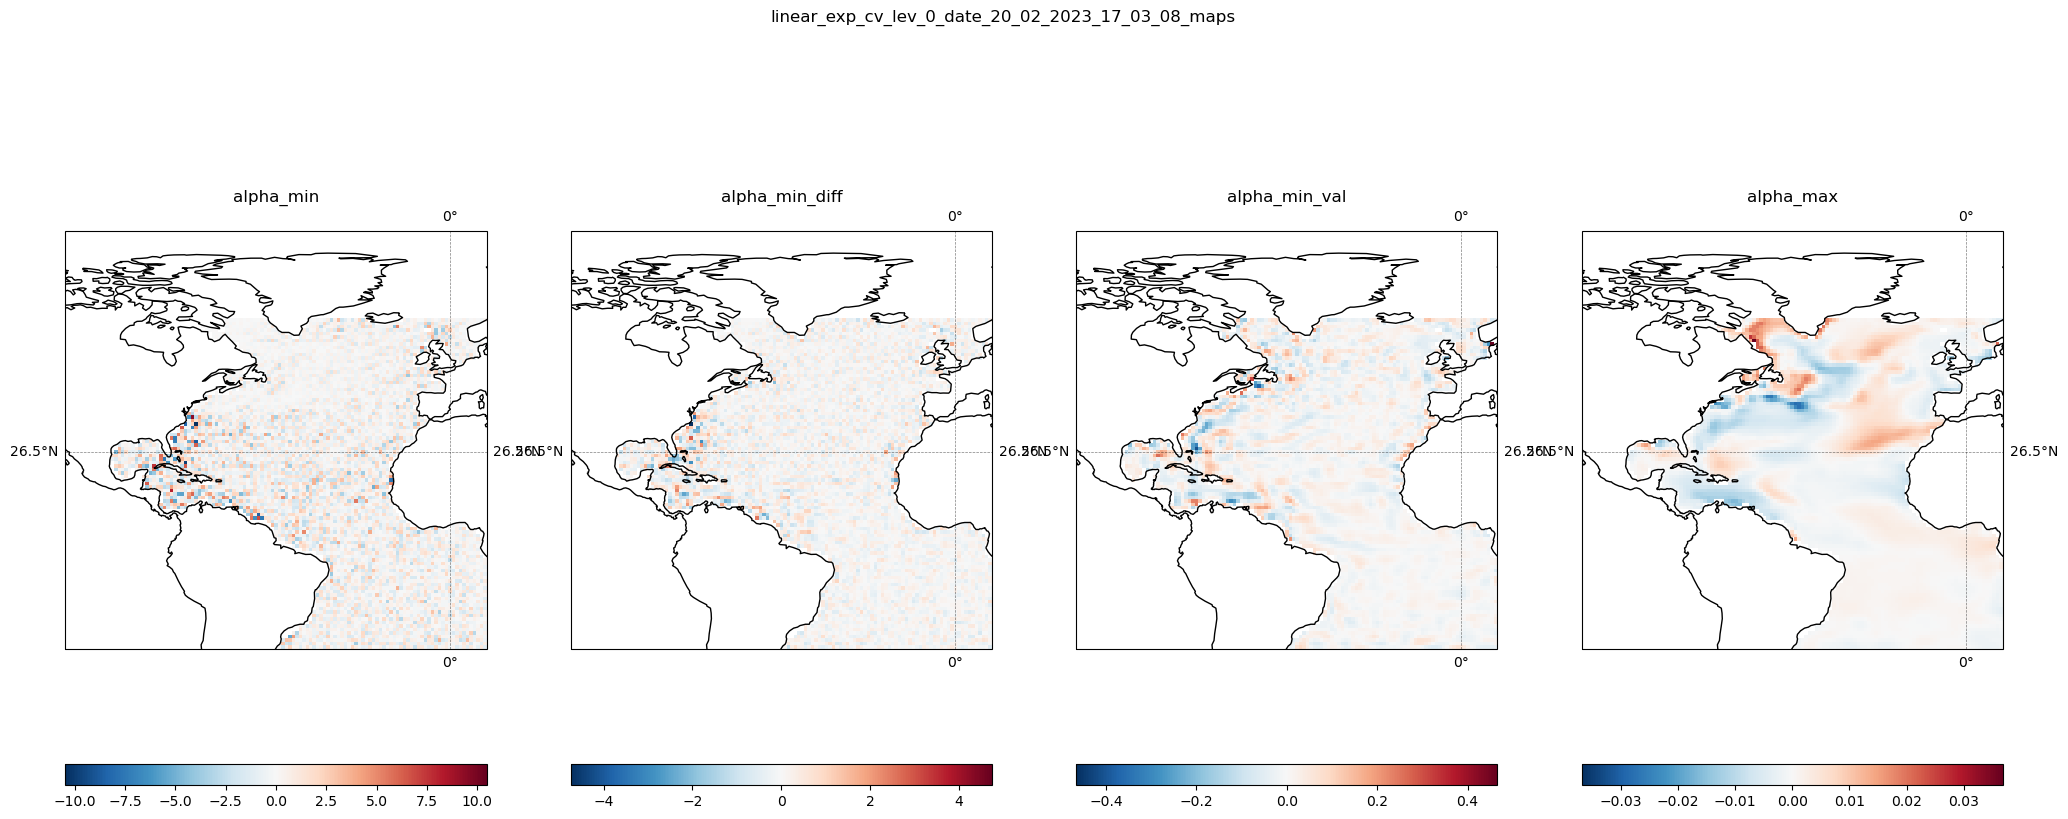

In [24]:
fig, ax  = plt.subplots(1,4,figsize=(25,10), subplot_kw = {"projection":ccrs.PlateCarree()})

ax_ravel = np.ravel(ax)


tmp = coefficients.sel(alpha=alpha_min, method="nearest")
vmax = np.abs(tmp).max()
plot = ax[0].pcolormesh(coefficients.lon, coefficients.lat, tmp.transpose("lat","lon"), vmin=-vmax, vmax= vmax,cmap="RdBu_r", transform=ccrs.PlateCarree())
plt.colorbar(plot, ax = ax[0], orientation="horizontal")


tmp = coefficients.sel(alpha=alpha_min_val, method="nearest")
vmax = np.abs(tmp).max()
plot = ax[1].pcolormesh(coefficients.lon, coefficients.lat, tmp.transpose("lat","lon"), vmin=-vmax, vmax=vmax, cmap="RdBu_r", transform=ccrs.PlateCarree())
plt.colorbar(plot, ax = ax[1], orientation="horizontal")

tmp = coefficients.sel(alpha=alpha_min_diff, method="nearest")
vmax = np.abs(tmp).max()
plot = ax[2].pcolormesh(coefficients.lon, coefficients.lat, tmp.transpose("lat","lon"), vmin=-vmax, vmax=vmax, cmap="RdBu_r", transform=ccrs.PlateCarree())
plt.colorbar(plot, ax = ax[2], orientation="horizontal")

tmp = coefficients.sel(alpha=alpha_max, method="nearest")
vmax = np.abs(tmp).max()
plot = ax[3].pcolormesh(coefficients.lon, coefficients.lat, tmp.transpose("lat","lon"), vmin=-vmax, vmax=vmax,cmap="RdBu_r", transform=ccrs.PlateCarree())
plt.colorbar(plot, ax = ax[3], orientation="horizontal")


ax[0].set_title("alpha_min")
ax[1].set_title("alpha_min_diff")
ax[2].set_title("alpha_min_val")
ax[3].set_title("alpha_max")

for i, ax in enumerate(ax_ravel):
    ax.coastlines()
    ax.gridlines(xlocs=[0], ylocs = [26.5], draw_labels=True, linewidth=0.5, color='k', alpha=0.5, linestyle='--')

name = "linear_exp_{}_lev_{}_date_{}_maps".format(exp_name, lev_index, datetime_string )
fig.suptitle(name)
plt.savefig(os.path.join(model_plot_path, name))



In [25]:
data_valid_pred_year = data["valid_pred"].unstack().assign_coords({"time":data["valid_pred"].unstack().time.dt.year}).dropna(dim="time", how="all")
data_train_pred_year = data["train_pred"].unstack().assign_coords({"time":data["train_pred"].unstack().time.dt.year}).dropna(dim="time", how="all")

In [26]:
data_valid_true_year = valid_y_true_ml_xr.unstack().assign_coords({"time":valid_y_true_ml_xr.unstack().time.dt.year})
data_train_true_year = train_y_true_ml_xr.unstack().assign_coords({"time":train_y_true_ml_xr.unstack().time.dt.year})

In [27]:
valid_pred_polyfit = data_valid_pred_year.polyfit(deg=1, dim="time")
train_pred_polyfit = data_train_pred_year.polyfit(deg=1, dim="time")

valid_true_polyfit = data_valid_true_year.polyfit(deg=1, dim="time")
train_true_polyfit = data_train_true_year.polyfit(deg=1, dim="time")

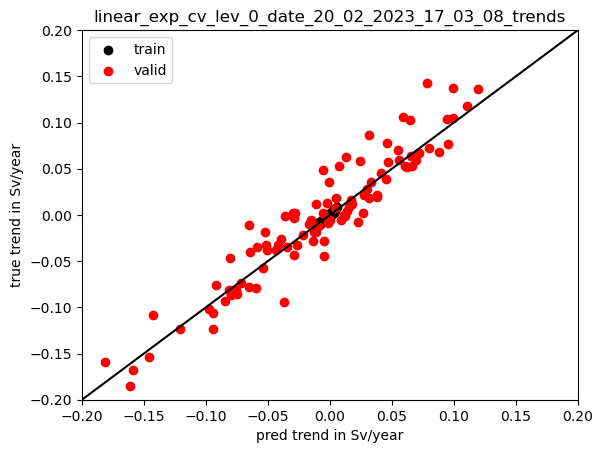

In [28]:
plt.scatter(train_pred_polyfit["polyfit_coefficients"].isel(degree=0).sel(alpha=alpha_min_val), train_true_polyfit["polyfit_coefficients"].isel(degree=0), color="black", label="train")
plt.scatter(valid_pred_polyfit["polyfit_coefficients"].isel(degree=0).sel(alpha=alpha_min_val), valid_true_polyfit["polyfit_coefficients"].isel(degree=0), color="red", label="valid")


plt.xlim(-0.2,0.2)
plt.ylim(-0.2,0.2)

x = np.arange(-2,2)

plt.plot(x,x, color="black")


plt.xlabel("pred trend in Sv/year")
plt.ylabel("true trend in Sv/year")

plt.legend()
name = "linear_exp_{}_lev_{}_date_{}_trends".format(exp_name, lev_index, datetime_string )
plt.title(name)
plt.savefig(os.path.join(model_plot_path, name))

